In [9]:
# --- IMPORTS BASIC LIBRARIES---
import pandas as pd
import numpy as np
import time
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

# --- IMPORT MODELS ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

In [10]:
# --- LOADING & CLEANING
print("1. Loading Data...")
dataset = fetch_ucirepo(id=296)
X = dataset.data.features
y = dataset.data.targets

# Fix Target (Yes/No -> 1/0)
y = y['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)

# Drop useless ID columns that confuse models
cols_to_drop = ['encounter_id', 'patient_nbr']
X = X.drop([c for c in cols_to_drop if c in X.columns], axis=1)

# Handle missing values ('?' -> NaN -> 'Missing')
X.replace('?', np.nan, inplace=True)
# Fill text columns with "Unknown" and number columns with 0 (Simplified Imputation)
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].fillna('Unknown')
    else:
        X[col] = X[col].fillna(0)

# Encoding (Text --> Numbers)
print("2. Encoding Data (Text -> Numbers)...")
X_encoded = pd.get_dummies(X, drop_first=True)

1. Loading Data...
2. Encoding Data (Text -> Numbers)...


In [11]:
# --- SPLITTING ---
print("3. Splitting Data...")
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=123, stratify=y)

# Scale data (Important for Logistic Regression & KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


3. Splitting Data...


In [12]:
# --- DEFINING THE MODELS ---
# This is the "Roster" of players

models = {
    "Logistic Regression" : LogisticRegression(max_iter=1000),
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest" : RandomForestClassifier(n_jobs=-1), # n_jobs=-1 uses all cores
    "Extra Trees" : ExtraTreesClassifier(n_jobs=-1),
    "Gradient Boosting" : GradientBoostingClassifier(),
    "AdaBoost" : AdaBoostClassifier(),
    "Naive Bayes" : GaussianNB(),
    "LightGBM" : lgb.LGBMClassifier(n_jobs=-1, verbose=1),
}

# Add XGBoost if installed
if HAS_XGB:
    models['XGBoost'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [21]:
# --- TRAINING LOOP (The Race) ---
print(f"\nStarting the Race with {len(models)} models...")
print("-" * 60)
print(f"{'Model Name':<25} | {'Accuracy':<10} | {'Time (s)':<10}")
print("-" * 60)

results = []

for name, model in models.items():
    start = time.time()

    # Special handling: Tree models don't need scaling, but LR/KNN do.
    # For simplicity, we use scaled data for everyone (Trees handle it fine).
    model.fit(X_train_scaled, y_train)

    # Predict
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)

    end = time.time()
    elapsed = end - start

    print(f"{name:<25} | {acc:.4f}      | {elapsed:.2f}")
    results.append((name, acc))

# -- WINNER ANNOUNCEMENT ---
results.sort(key=lambda x: x[1], reverse=True)
print('-' * 60)
print(f"Winner: {results[0][0]} with {results[0][1]:.2%} accuracy")


Starting the Race with 9 models...
------------------------------------------------------------
Model Name                | Accuracy   | Time (s)  
------------------------------------------------------------
Logistic Regression       | 0.6258      | 10.34
Decision Tree             | 0.5788      | 7.54
Random Forest             | 0.6481      | 21.08
Extra Trees               | 0.6349      | 35.80
Gradient Boosting         | 0.6456      | 92.28


/Users/azhar/Documents/python learning/machine_learning_practice/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost                  | 0.6406      | 78.53
Naive Bayes               | 0.4724      | 4.52
[LightGBM] [Info] Number of positive: 32831, number of negative: 38405
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3024
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 903
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460877 -> initscore=-0.156814
[LightGBM] [Info] Start training from score -0.156814
LightGBM                  | 0.6569      | 5.03


/Users/azhar/Documents/python learning/machine_learning_practice/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [00:07:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost                   | 0.6522      | 4.89
------------------------------------------------------------
Winner: LightGBM with 65.69% accuracy


In [13]:
# --- The "Feature Importance" ---
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import re

# Create Function to Removing Weird symbols
def clean_col_names(df):
    new_columns = []
    for col in df.columns:
        # Replace brackets, commas, spaces with underscores
        clean_name = re.sub(r'[^A-Za-z0-9_]', '_', col)
        new_columns.append(clean_name)
    return new_columns

X_train.columns = clean_col_names(X_train)
X_test.columns = clean_col_names(X_test)

print("Retraining LightGBM for interpretation...")
lgb_model = lgb.LGBMClassifier(n_jobs=-1, verbose=-1)
lgb_model.fit(X_train, y_train)

# Create the Explainer
# This is the "Translator" that converts math into exlanations
explainer = shap.TreeExplainer(lgb_model)

# Calculate SHAP values
print("Calculating SHAP values (this might take 30 seconds)...")
shap_values = explainer.shap_values(X_test.iloc[:1000])

print("Done! Ready to plot.")

Retraining LightGBM for interpretation...
Calculating SHAP values (this might take 30 seconds)...
Done! Ready to plot.


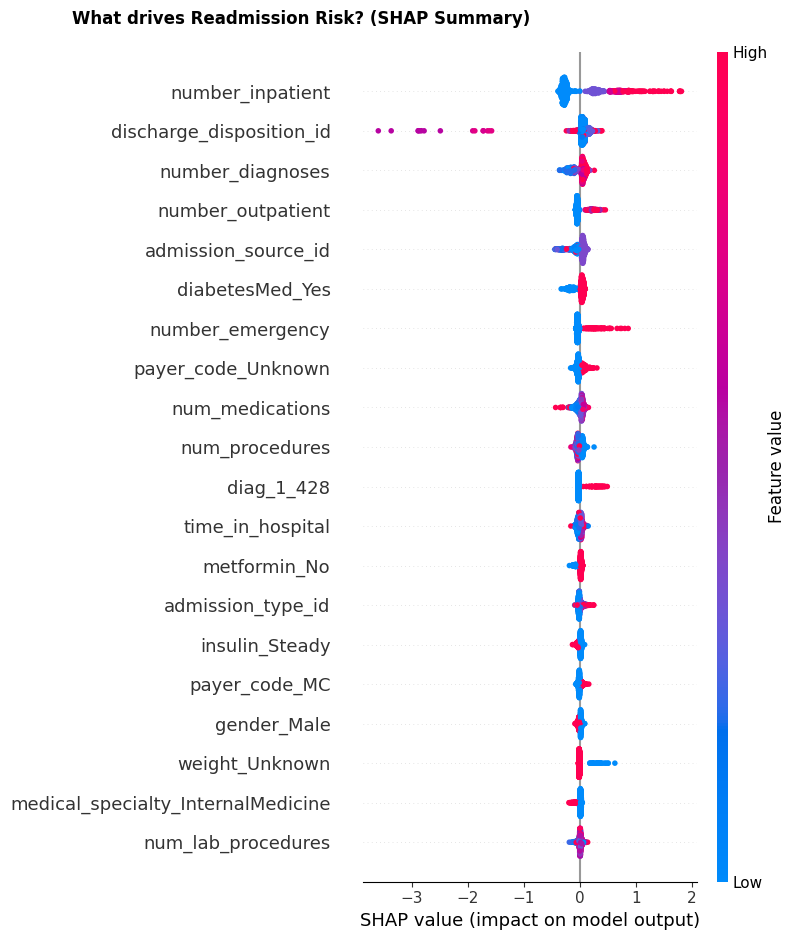

In [24]:
# Generate the Summary Plot
plt.title("What drives Readmission Risk? (SHAP Summary)", fontsize=12, weight='bold', ha='right', pad=20)
shap.summary_plot(shap_values, X_test.iloc[:1000], plot_type="dot")

In [25]:
# Initialize JS
shap.initjs()

# Check if expected_value is a number or a list
# If it's a list/array, take the last value. If it's a number, use it directly.
if isinstance(explainer.expected_value, list) or len(explainer.expected_value.shape) > 0:
    base_value = explainer.expected_value[-1] # Take the 'Yes' value
else:
    base_value = explainer.expected_value

# Force Plot for Patient #5
# Notice we use shap_values[5] directly (no [1])
shap.force_plot(
    base_value, 
    shap_values[5], 
    X_test.iloc[5,:]
)

### **TUNING**

In [26]:
from sklearn.model_selection import RandomizedSearchCV

# Define the "Grid" of settings we want to test
# These are the knobs we'll twist
param_grid = {
    'num_leaves': [20, 31, 50, 70],       # Complexity of the tree (Default is 31)
    'learning_rate': [0.01, 0.05, 0.1],   # How fast it learns (Lower is slower but more precise)
    'n_estimators': [100, 200, 500],      # Number of trees to build
    'max_depth': [-1, 10, 20],            # How deep the tree can grow (-1 means no limit)
    'reg_alpha': [0, 0.1, 0.5],           # L1 Regularization (prevents overfitting)
    'reg_lambda': [0, 0.1, 0.5]           # L2 Regularization (prevents overfitting)
}


# Setup the Search
# We use the clean-name LightGBM model we made earlier
lgb_base = lgb.LGBMClassifier(random_state=123, verbose=-1, n_jobs=-1)

# n_iter=20 means "Try 20 random combinations"
# cv=3 means "Test each combination 3 times to be sure"
search = RandomizedSearchCV(
    estimator = lgb_base,
    param_distributions = param_grid,
    n_iter = 20,
    scoring = 'accuracy',
    cv = 3,
    verbose = 1,
    random_state = 42,
    n_jobs = -1
)

# Run the Search (The Heavy Lifting)
print("Starting Hyperparameter Tuning...")
start_time = time.time()

# Make sure we use the version with clean column names!
search.fit(X_train, y_train)

end_time = time.time()

# The Results
print("-" * 50)
print(f"Done in {(end_time - start_time):.2f} seconds.")
print(f"Best Accuracy found: {search.best_score_:.4%}")
print("-" * 50)
print("The Winning Settings (Hyperparameters):")
print(search.best_params_)

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
--------------------------------------------------
Done in 227.10 seconds.
Best Accuracy found: 65.0851%
--------------------------------------------------
The Winning Settings (Hyperparameters):
{'reg_lambda': 0, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.05}


In [28]:
# Grab the winner from the random search
tuned_model = search.best_estimator_

# Predict on the Test Set (The Final Exam)
preds_tuned = tuned_model.predict(X_test)
acc_tuned = accuracy_score(y_test, preds_tuned)

print(f"Default Model Accuracy: 65.69%") # From the previous run
print(f"Tuned Model Accuracy: {acc_tuned:.2f}")

if acc_tuned > 0.6569:
    print("Tuning IMPROVED the model!")
else:
    print("Tuning didn't help much (Defaults were already optimal).")


Default Model Accuracy: 65.69%
Tuned Model Accuracy: 0.66
Tuning IMPROVED the model!


### **FINALIZE** 

In [29]:
import joblib

# Merge Train and Test data back together
# We want the model to learn from EVERY patient before we ship it
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

print(f"Training final model on {len(X_full)} patients...")

# Create the Final Model using the best settings we found
# We use the **kwargs trick to unpack the dictionary of settings
final_model = lgb.LGBMClassifier(**search.best_params_, random_state=123, verbose=-1, n_jobs=-1)

# Fit on All data
final_model.fit(X_full, y_full)

# Save to a file (Pickle/Joblib)
# This creates a file on your hard drive
joblib.dump(final_model, 'hospital_readmission_model_v1.pkl')
joblib.dump(list(X_full.columns), 'model_features.pkl')     # Save column names too!

print("Model saved successfully as 'hospital_readmission_model_v1.pkl")
print("Feature list saved as 'model_features.pkl")

Training final model on 101766 patients...
Model saved successfully as 'hospital_readmission_model_v1.pkl
Feature list saved as 'model_features.pkl
